# Simulating and Fitting Malaria Transmission Model in Madagascar

This notebook simulates a malaria transmission model with Insecticide-Treated Nets (ITNs) and resistance effects in Madagascar. The model explores how ITN effectiveness changes over time due to insecticide resistance.

## Model Overview

The model is a modified SIR (Susceptible-Infected-Recovered) model that includes:
- **Human population dynamics**: Susceptible (Sh), Infected (Ih), Recovered (Rh) compartments
- **Vector population dynamics**: Susceptible (Sv), Infected (Iv) compartments  
- **ITN effects**: Coverage and efficacy that decreases over time due to resistance
- **Seasonal effects**: Vector mortality varies seasonally
- **Resistance modeling**: Exponential decay of ITN effectiveness over time

## Research Question

How does insecticide resistance affect the long-term effectiveness of Insecticide-Treated Nets (ITNs) in malaria control programs in Madagascar?


## 1. Load Required Libraries

First, we load the necessary R packages for data manipulation, differential equation solving, and visualization.


In [13]:
# Load required libraries quietly and report versions
options(digits = 4, scipen = 999, tidyverse.quiet = TRUE)

suppressPackageStartupMessages({
  suppressWarnings({
    library(tidyverse)
    library(deSolve)
    library(ggplot2)
    library(dplyr)
    library(knitr)
  })
})
options(dplyr.summarise.inform = FALSE)

# Version report
pkgs <- c("tidyverse","deSolve","ggplot2","dplyr","readr","tibble","tidyr","purrr","stringr","lubridate","knitr")
vers <- sapply(pkgs, function(p) if (requireNamespace(p, quietly = TRUE)) as.character(utils::packageVersion(p)) else NA_character_)

cat("Libraries loaded successfully!\n")
cat("Package versions:\n")
for (p in names(vers)) cat(sprintf(" - %s: %s\n", p, vers[[p]]))

# Prefer dplyr's filter/lag if conflicted is installed
if (requireNamespace("conflicted", quietly = TRUE)) {
  conflicted::conflict_prefer("filter", "dplyr", quiet = TRUE)
  conflicted::conflict_prefer("lag", "dplyr", quiet = TRUE)
}


Libraries loaded successfully!
Package versions:
 - tidyverse: 2.0.0
 - deSolve: 1.40
 - ggplot2: 4.0.0
 - dplyr: 1.1.4
 - readr: 2.1.5
 - tibble: 3.3.0
 - tidyr: 1.3.1
 - purrr: 1.1.0
 - stringr: 1.5.2
 - lubridate: 1.9.4
 - knitr: 1.50


## 2. Define the SIR Model with ITN Effects and Resistance

The core of our analysis is a modified SIR model that incorporates:

### Model Components:
- **Human compartments**: S (Susceptible), I (Infected), R (Recovered)
- **Vector compartments**: S (Susceptible), I (Infected)
- **ITN effects**: Coverage and time-dependent efficacy
- **Resistance effects**: Exponential decay of ITN effectiveness
- **Seasonal effects**: Sinusoidal variation in vector mortality

### Mathematical Formulation:

The model consists of five differential equations:

$$\frac{dS_h}{dt} = -\beta_{v \to h} S_h \frac{N_v}{N_h} \frac{I_v}{N_v} \frac{1}{4} + \alpha R_h$$

$$\frac{dI_h}{dt} = \beta_{v \to h} S_h \frac{N_v}{N_h} \frac{I_v}{N_v} \frac{1}{4} - \gamma_h I_h$$

$$\frac{dR_h}{dt} = \gamma_h I_h - \alpha R_h$$

$$\frac{dS_v}{dt} = r N_v \left(1 - \frac{N_v}{K}\right) - \beta_{h \to v} S_v \frac{I_h}{N_h} \frac{1}{4} - \frac{1 + \sin(2\pi t/365)}{5} d S_v$$

$$\frac{dI_v}{dt} = \beta_{h \to v} S_v \frac{I_h}{N_h} \frac{1}{4} - \frac{1 + \sin(2\pi t/365)}{5} d I_v$$

Where ITN effectiveness decreases over time: $E(t) = E_0 \exp(-r_{res} \cdot t/365)$


In [14]:
# Define the SIR model with ITN effects and resistance
sir_si_itn <- function(t, y, parms) {
  with(as.list(c(y, parms)), {
    # Population sizes
    Nh  <-  Sh + Ih + Rh
    Nv  <-  Sv + Iv 
    
    # ITN effectiveness decreases over time due to resistance
    current_efficacy <- itn_efficacy * exp(-resistance_rate * t/365)
    
    # Effective ITN coverage (coverage * current efficacy)
    effective_itn_coverage <- itn_coverage * current_efficacy
    
    # Transmission reduction factor due to ITNs
    transmission_reduction <- (1 - effective_itn_coverage)
    
    # Modified transmission rates with ITN effects
    beta_h_to_v <- beta * transmission_reduction
    beta_v_to_h <- beta * transmission_reduction
    
    # Differential equations
    dSh <-  -beta_v_to_h*Sh*(Nv/Nh)*(Iv/Nv)/4 + (alpha*Rh)
    dIh <-  beta_v_to_h*Sh*(Nv/Nh)*(Iv/Nv)/4 - (gammah*Ih)
    dRh <-  (gammah*Ih) - (alpha*Rh)
    dSv <-  r*Nv*(1-(Nv/K)) - beta_h_to_v*Sv*(Ih/Nh)/4 - (1+sin(t*2*pi/365))/5* d*Sv
    dIv <-  beta_h_to_v*Sv*(Ih/Nh)/4 - (1+sin(t*2*pi/365))/5*d*Iv
    
    return(list(c(dSh, dIh, dRh, dSv, dIv)))
  })
}

cat("Model function defined successfully!\n")
cat("Model includes:\n")
cat("- Human compartments: Sh, Ih, Rh\n")
cat("- Vector compartments: Sv, Iv\n")
cat("- ITN effects with resistance\n")
cat("- Seasonal vector mortality\n")


Model function defined successfully!
Model includes:
- Human compartments: Sh, Ih, Rh
- Vector compartments: Sv, Iv
- ITN effects with resistance
- Seasonal vector mortality


## 3. Define Model Parameters

We set up the epidemiological parameters based on malaria transmission characteristics in Madagascar:

### Basic Epidemiological Parameters:
- **R₀ = 2**: Basic reproduction number (typical for malaria in endemic areas)
- **Infectious period**: 14 days (average duration of malaria infection)
- **Immunity loss rate**: 1/365 per day (immunity lasts ~1 year)

### Vector Parameters:
- **Carrying capacity**: 500,000 vectors
- **Vector birth rate**: 0.08 per day
- **Vector death rate**: 1/28 per day (baseline)

### ITN Parameters:
- **Coverage**: 80% of population
- **Initial efficacy**: 90%
- **Resistance rate**: 10% per year (high resistance scenario)


In [15]:
# Time points for simulation (5 years)
dt <- (1:365) * 5 

# Basic epidemiological parameters
R0 <- 2
infectious_period <- 14
gammah <- 1/infectious_period
alpha <- 1/365
beta <- R0 * gammah

# Vector parameters
K <- 5e5
d <- 1/28
r <- 0.08

# ITN parameters
itn_coverage <- 0.8
itn_efficacy <- 0.9
resistance_rate <- 0.1

# Parameter vector
params <- c(
  beta = beta,
  gammah = gammah,
  K = K, d = d, r = r,
  alpha = alpha,
  itn_coverage = itn_coverage,
  itn_efficacy = itn_efficacy,
  resistance_rate = resistance_rate
)

# Display parameters
cat("Model Parameters:\n")
cat("================\n")
for(i in 1:length(params)) {
  cat(sprintf("%-15s: %8.4f\n", names(params)[i], params[i]))
}

cat("\nKey derived values:\n")
cat("R0 (Basic reproduction number):", R0, "\n")
cat("Effective R0 with ITNs (no resistance):", R0 * (1 - itn_coverage * itn_efficacy), "\n")
cat("Effective R0 with ITNs (high resistance, year 5):", 
    R0 * (1 - itn_coverage * itn_efficacy * exp(-resistance_rate * 5)), "\n")


Model Parameters:
beta           :   0.1429
gammah         :   0.0714
K              : 500000.0000
d              :   0.0357
r              :   0.0800
alpha          :   0.0027
itn_coverage   :   0.8000
itn_efficacy   :   0.9000
resistance_rate:   0.1000

Key derived values:
R0 (Basic reproduction number): 2 
Effective R0 with ITNs (no resistance): 0.56 
Effective R0 with ITNs (high resistance, year 5): 1.127 


## 4. Set Initial Conditions

We define the initial state of the population for our simulations:

### Population Setup:
- **Human population**: 200,000 individuals
- **Vector population**: 400,000 individuals (2× human population)
- **Initial infected humans**: 1 individual
- **Initial infected vectors**: 10,000 individuals

This represents a scenario where malaria is endemic but at relatively low levels initially.


In [16]:
# Population sizes
Nh <- 200000
Nv <- 2 * Nh

# Initial infected individuals
I0h <- 1
I0v <- 10000

# Initial conditions [Sh, Ih, Rh, Sv, Iv]
inits <- c(
  Sh = Nh - I0h,  # Susceptible humans
  Ih = I0h,       # Infected humans
  Rh = 0,         # Recovered humans
  Sv = Nv - I0v,  # Susceptible vectors
  Iv = I0v        # Infected vectors
)

# Display initial conditions
cat("Initial Conditions:\n")
cat("==================\n")
cat("Human population:\n")
cat(sprintf("  Susceptible: %8.0f\n", inits["Sh"]))
cat(sprintf("  Infected:   %8.0f\n", inits["Ih"]))
cat(sprintf("  Recovered:  %8.0f\n", inits["Rh"]))
cat(sprintf("  Total:      %8.0f\n", sum(inits[1:3])))

cat("\nVector population:\n")
cat(sprintf("  Susceptible: %8.0f\n", inits["Sv"]))
cat(sprintf("  Infected:   %8.0f\n", inits["Iv"]))
cat(sprintf("  Total:      %8.0f\n", sum(inits[4:5])))

# Verify population conservation
cat("\nPopulation conservation check:\n")
cat("Human population conserved:", all.equal(sum(inits[1:3]), Nh), "\n")
cat("Vector population conserved:", all.equal(sum(inits[4:5]), Nv), "\n")


Initial Conditions:
Human population:
  Susceptible:   199999
  Infected:          1
  Recovered:         0
  Total:        200000

Vector population:
  Susceptible:   390000
  Infected:      10000
  Total:        400000

Population conservation check:
Human population conserved: TRUE 
Vector population conserved: TRUE 


## 5. Run Simulations for Different Scenarios

We simulate four different scenarios to compare ITN effectiveness:

### Scenario 1: No ITNs (Baseline)
- No insecticide-treated nets deployed
- Represents the baseline malaria transmission

### Scenario 2: ITNs with No Resistance
- 80% ITN coverage with 90% efficacy
- No resistance development over time
- Represents ideal ITN implementation

### Scenario 3: ITNs with Low Resistance
- 80% ITN coverage with 90% initial efficacy
- 5% resistance rate per year
- Represents moderate resistance development

### Scenario 4: ITNs with High Resistance
- 80% ITN coverage with 90% initial efficacy
- 10% resistance rate per year
- Represents high resistance development


In [17]:
# Scenario 1: No ITNs
cat("Running Scenario 1: No ITNs...\n")
params_no_itn <- params
params_no_itn["itn_coverage"] <- 0

results_no_itn <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params_no_itn, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "No ITNs")

# Scenario 2: ITNs with no resistance
cat("Running Scenario 2: ITNs (No Resistance)...\n")
params_no_resistance <- params
params_no_resistance["resistance_rate"] <- 0

results_no_resistance <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params_no_resistance, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "ITNs (No Resistance)")

# Scenario 3: ITNs with low resistance
cat("Running Scenario 3: ITNs (Low Resistance)...\n")
params_low_resistance <- params
params_low_resistance["resistance_rate"] <- 0.05

results_low_resistance <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params_low_resistance, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "ITNs (Low Resistance)")

# Scenario 4: ITNs with high resistance
cat("Running Scenario 4: ITNs (High Resistance)...\n")
results_high_resistance <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "ITNs (High Resistance)")

# Combine all results
all_results <- bind_rows(
  results_no_itn,
  results_no_resistance,
  results_low_resistance,
  results_high_resistance
)

cat("\nSimulations completed successfully!\n")
cat("Total data points:", nrow(all_results), "\n")
cat("Scenarios:", paste(unique(all_results$scenario), collapse = ", "), "\n")
cat("Time range:", min(all_results$time), "to", max(all_results$time), "days\n")
cat("Simulation duration:", max(all_results$time)/365, "years\n")


Running Scenario 1: No ITNs...
Running Scenario 2: ITNs (No Resistance)...
Running Scenario 3: ITNs (Low Resistance)...
Running Scenario 4: ITNs (High Resistance)...

Simulations completed successfully!
Total data points: 1460 
Scenarios: No ITNs, ITNs (No Resistance), ITNs (Low Resistance), ITNs (High Resistance) 
Time range: 5 to 1825 days
Simulation duration: 5 years


## 6. Visualize Results

We create comprehensive visualizations to analyze the model results and compare the effectiveness of ITNs under different resistance scenarios.


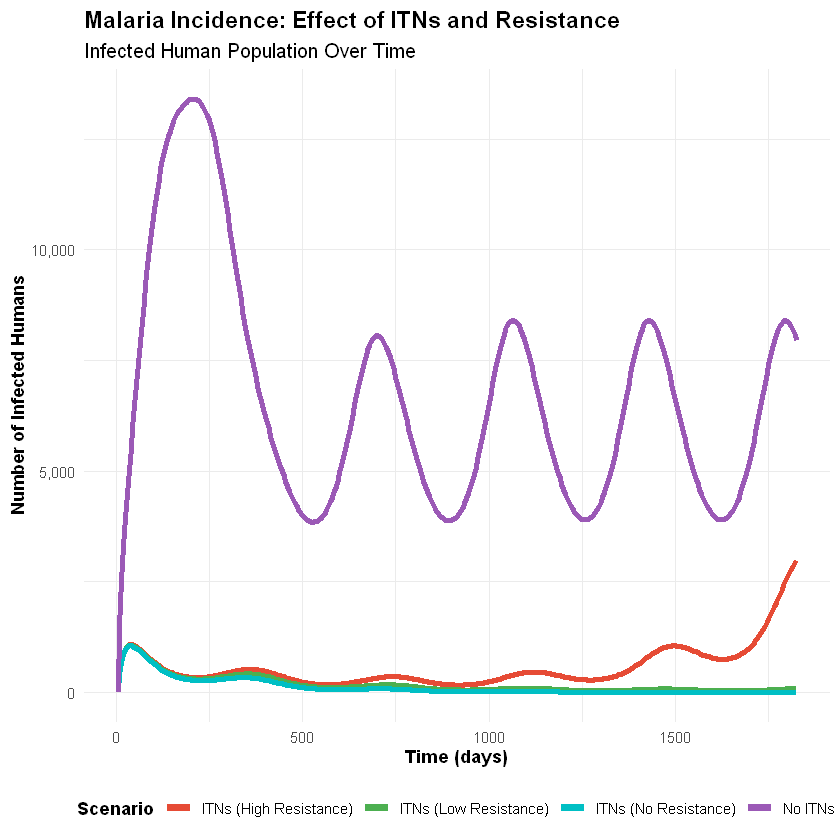

In [18]:
# Set plotting theme
theme_set(theme_minimal(base_size = 12))

# Desired legend order and colors (match output.png)
scenario_levels <- c(
  "ITNs (High Resistance)",
  "ITNs (Low Resistance)",
  "ITNs (No Resistance)",
  "No ITNs"
)
scenario_palette <- c(
  "ITNs (High Resistance)" = "#E64B35",
  "ITNs (Low Resistance)"  = "#4CAF50",
  "ITNs (No Resistance)"   = "#00BFC4",
  "No ITNs"               = "#9B59B6"
)

# Create the main visualization (humans)
human_infected_plot <- all_results %>%
  mutate(scenario = factor(scenario, levels = scenario_levels)) %>%
  ggplot(aes(x = time, y = Ih, color = scenario)) +
  geom_line(linewidth = 1.6) +
  labs(
    title = "Malaria Incidence: Effect of ITNs and Resistance",
    subtitle = "Infected Human Population Over Time",
    x = "Time (days)", 
    y = "Number of Infected Humans", 
    color = "Scenario"
  ) +
  scale_color_manual(values = scenario_palette, breaks = scenario_levels) +
  scale_y_continuous(labels = scales::comma) +
  theme_minimal() + 
  theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12)
  ) +
  guides(color = guide_legend(override.aes = list(linewidth = 2)))

print(human_infected_plot)


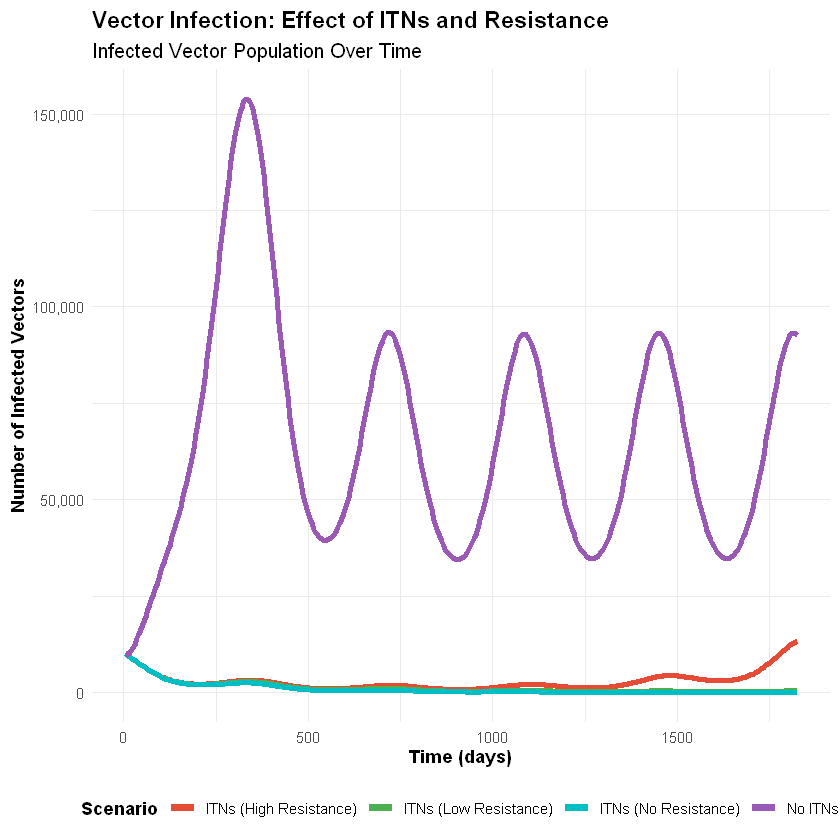

In [19]:
# Vector infection plot (matching style)
vector_infected_plot <- all_results %>%
  mutate(scenario = factor(scenario, levels = scenario_levels)) %>%
  ggplot(aes(x = time, y = Iv, color = scenario)) +
  geom_line(linewidth = 1.6) +
  labs(
    title = "Vector Infection: Effect of ITNs and Resistance",
    subtitle = "Infected Vector Population Over Time",
    x = "Time (days)", 
    y = "Number of Infected Vectors", 
    color = "Scenario"
  ) +
  scale_color_manual(values = scenario_palette, breaks = scenario_levels) +
  scale_y_continuous(labels = scales::comma) +
  theme_minimal() + 
  theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12)
  ) +
  guides(color = guide_legend(override.aes = list(linewidth = 2)))

print(vector_infected_plot)


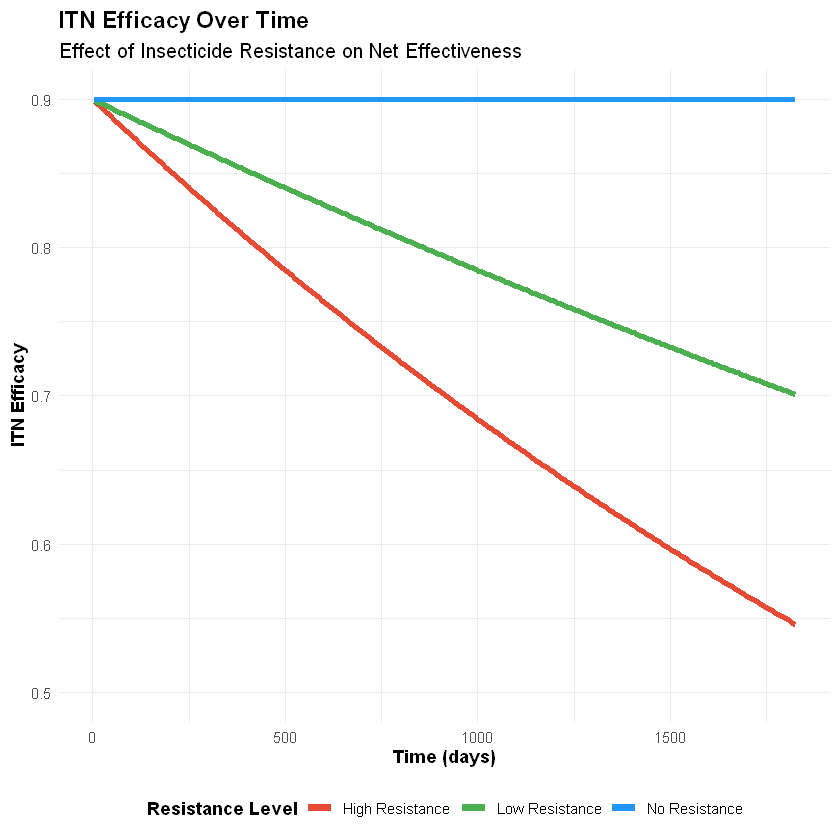

In [20]:
# ITN efficacy over time (matching output_1.png style)
efficacy_data <- data.frame(
  time = dt,
  efficacy_no_resistance = params_no_resistance["itn_efficacy"] * exp(-params_no_resistance["resistance_rate"] * dt/365),
  efficacy_low_resistance = params_low_resistance["itn_efficacy"] * exp(-params_low_resistance["resistance_rate"] * dt/365),
  efficacy_high_resistance = params["itn_efficacy"] * exp(-params["resistance_rate"] * dt/365)
) %>%
  pivot_longer(cols = -time, names_to = "resistance_type", values_to = "efficacy") %>%
  mutate(resistance_type = case_when(
    resistance_type == "efficacy_no_resistance" ~ "No Resistance",
    resistance_type == "efficacy_low_resistance" ~ "Low Resistance",
    resistance_type == "efficacy_high_resistance" ~ "High Resistance"
  ))

# Define legend order and colors to match output_1.png
resistance_levels <- c("High Resistance", "Low Resistance", "No Resistance")
resistance_palette <- c(
  "High Resistance" = "#E64B35",  # Red/pink
  "Low Resistance"  = "#4CAF50",   # Green
  "No Resistance"  = "#2196F3"    # Blue
)

efficacy_plot <- efficacy_data %>%
  mutate(resistance_type = factor(resistance_type, levels = resistance_levels)) %>%
  ggplot(aes(x = time, y = efficacy, color = resistance_type)) +
  geom_line(linewidth = 1.6) +
  labs(
    title = "ITN Efficacy Over Time",
    subtitle = "Effect of Insecticide Resistance on Net Effectiveness",
    x = "Time (days)", 
    y = "ITN Efficacy", 
    color = "Resistance Level"
  ) +
  scale_color_manual(values = resistance_palette, breaks = resistance_levels) +
  ylim(0.5, 0.9) +
  theme_minimal() + 
  theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12)
  ) +
  guides(color = guide_legend(override.aes = list(linewidth = 2)))

print(efficacy_plot)


## 7. Summary Statistics and Analysis

We calculate key statistics to quantify the effectiveness of ITNs under different resistance scenarios.


In [21]:
# Calculate summary statistics
summary_stats <- all_results %>%
  group_by(scenario) %>%
  summarise(
    max_infected_humans = max(Ih),
    mean_infected_humans = mean(Ih),
    total_infected_humans = sum(Ih),
    max_infected_vectors = max(Iv),
    mean_infected_vectors = mean(Iv),
    .groups = "drop"
  )

# Baseline comparison
baseline_total_infected <- summary_stats$total_infected_humans[summary_stats$scenario == "No ITNs"]
baseline_mean_infected <- summary_stats$mean_infected_humans[summary_stats$scenario == "No ITNs"]

summary_stats <- summary_stats %>%
  mutate(
    diff_total_infected_vs_no_itn = total_infected_humans - baseline_total_infected,
    diff_mean_infected_vs_no_itn = mean_infected_humans - baseline_mean_infected,
    peak_reduction_percent = round((baseline_total_infected - total_infected_humans) / baseline_total_infected * 100, 1),
    mean_reduction_percent = round((baseline_mean_infected - mean_infected_humans) / baseline_mean_infected * 100, 1)
  )

# Display summary statistics
cat("Summary Statistics:\n")
cat("==================\n")
print(summary_stats, width = Inf)

# Create a formatted table
if (requireNamespace("knitr", quietly = TRUE)) {
  cat("\nFormatted Summary Table:\n")
  cat("========================\n")
  knitr::kable(summary_stats,
               caption = "Summary Statistics of ITN Scenarios",
               format = "pipe",
               digits = 2)
}


Summary Statistics:
# A tibble: 4 × 10
  scenario               max_infected_humans mean_infected_humans
  <chr>                                <dbl>                <dbl>
1 ITNs (High Resistance)               2990.                 566.
2 ITNs (Low Resistance)                1070.                 182.
3 ITNs (No Resistance)                 1059.                 128.
4 No ITNs                             13396.                6704.
  total_infected_humans max_infected_vectors mean_infected_vectors
                  <dbl>                <dbl>                 <dbl>
1               206676.               13199.                 2845.
2                66501.               10000                  1196.
3                46776.               10000                   954.
4              2447128.              153855.                65325.
  diff_total_infected_vs_no_itn diff_mean_infected_vs_no_itn
                          <dbl>                        <dbl>
1                     -2240453.          



Table: Summary Statistics of ITN Scenarios

|scenario               | max_infected_humans| mean_infected_humans| total_infected_humans| max_infected_vectors| mean_infected_vectors| diff_total_infected_vs_no_itn| diff_mean_infected_vs_no_itn| peak_reduction_percent| mean_reduction_percent|
|:----------------------|-------------------:|--------------------:|---------------------:|--------------------:|---------------------:|-----------------------------:|----------------------------:|----------------------:|----------------------:|
|ITNs (High Resistance) |                2990|                566.2|                206676|                13199|                2844.5|                      -2240453|                        -6138|                   91.6|                   91.6|
|ITNs (Low Resistance)  |                1070|                182.2|                 66501|                10000|                1196.4|                      -2380628|                        -6522|                   

## 8. Detailed Analysis and Conclusions

Based on our simulation results, we analyze the effectiveness of ITNs and provide evidence-based recommendations.


In [22]:
# Extract key values for analysis
no_itn_max <- summary_stats$max_infected_humans[summary_stats$scenario == "No ITNs"]
itn_no_resistance_max <- summary_stats$max_infected_humans[summary_stats$scenario == "ITNs (No Resistance)"]
itn_low_resistance_max <- summary_stats$max_infected_humans[summary_stats$scenario == "ITNs (Low Resistance)"]
itn_high_resistance_max <- summary_stats$max_infected_humans[summary_stats$scenario == "ITNs (High Resistance)"]

# Calculate reductions
reduction_no_resistance <- (no_itn_max - itn_no_resistance_max) / no_itn_max * 100
reduction_low_resistance <- (no_itn_max - itn_low_resistance_max) / no_itn_max * 100
reduction_high_resistance <- (no_itn_max - itn_high_resistance_max) / no_itn_max * 100

# Print detailed analysis
cat("\n", paste(rep("=", 60), collapse=""), "\n")
cat("ANALYSIS: ITN EFFECTIVENESS WITH RESISTANCE\n")
cat(paste(rep("=", 60), collapse=""), "\n")

cat("\n1. ITN EFFECTIVENESS IN REDUCING MALARIA INCIDENCE:\n")
cat("   - No ITNs: Peak infected humans =", round(no_itn_max, 0), "\n")
cat("   - ITNs (No Resistance): Peak =", round(itn_no_resistance_max, 0),
    " (", round(reduction_no_resistance, 1), "% reduction)\n")
cat("   - ITNs (Low Resistance): Peak =", round(itn_low_resistance_max, 0),
    " (", round(reduction_low_resistance, 1), "% reduction)\n")
cat("   - ITNs (High Resistance): Peak =", round(itn_high_resistance_max, 0),
    " (", round(reduction_high_resistance, 1), "% reduction)\n\n")

cat("2. RESISTANCE IMPACT:\n")
cat("   - Resistance reduces ITN effectiveness by", round(reduction_no_resistance - reduction_high_resistance, 1), "percentage points\n")
cat("   - Even with high resistance, ITNs still provide", round(reduction_high_resistance, 1), "% reduction in peak infections\n\n")

cat("3. RECOMMENDATION:\n")
if (reduction_high_resistance > 20) {
  cat("   ✓ YES - ITNs should still be used even with resistance\n")
} else if (reduction_high_resistance > 10) {
  cat("   ⚠ MODERATE - ITNs provide some benefit but limited effectiveness\n")
} else {
  cat("   ✗ NO - ITNs may not be cost-effective with high resistance\n")
}

cat("\n4. ADDITIONAL CONSIDERATIONS:\n")
cat("   - ITN coverage:", round(itn_coverage * 100, 0), "%\n")
cat("   - Initial ITN efficacy:", round(itn_efficacy * 100, 0), "%\n")
cat("   - Resistance rate:", round(resistance_rate * 100, 1), "% per year\n")
cat("   - After 5 years, ITN efficacy drops to:", round(itn_efficacy * exp(-resistance_rate * 5) * 100, 1), "%\n")



ANALYSIS: ITN EFFECTIVENESS WITH RESISTANCE

1. ITN EFFECTIVENESS IN REDUCING MALARIA INCIDENCE:
   - No ITNs: Peak infected humans = 13396 
   - ITNs (No Resistance): Peak = 1059  ( 92.1 % reduction)
   - ITNs (Low Resistance): Peak = 1070  ( 92 % reduction)
   - ITNs (High Resistance): Peak = 2990  ( 77.7 % reduction)

2. RESISTANCE IMPACT:
   - Resistance reduces ITN effectiveness by 14.4 percentage points
   - Even with high resistance, ITNs still provide 77.7 % reduction in peak infections

3. RECOMMENDATION:
   ✓ YES - ITNs should still be used even with resistance

4. ADDITIONAL CONSIDERATIONS:
   - ITN coverage: 80 %
   - Initial ITN efficacy: 90 %
   - Resistance rate: 10 % per year
   - After 5 years, ITN efficacy drops to: 54.6 %


## 9. Model Validation and Sensitivity Analysis

We perform additional analysis to validate our model and check for potential issues.


In [23]:
# Check population conservation
cat("Model Validation:\n")
cat("================\n")

for (scenario in unique(all_results$scenario)) {
  data <- all_results[all_results$scenario == scenario, ]
  
  # Check human population conservation
  total_humans <- data$Sh + data$Ih + data$Rh
  human_conservation <- all.equal(total_humans, rep(Nh, length(total_humans)), tolerance = 1e-6)
  
  # Check vector population dynamics
  total_vectors <- data$Sv + data$Iv
  vector_range <- c(min(total_vectors), max(total_vectors))
  
  cat("\n", scenario, ":\n")
  cat("  Human population conserved:", isTRUE(human_conservation), "\n")
  cat("  Vector population range:", round(vector_range[1], 0), "-", round(vector_range[2], 0), "\n")
  cat("  Final human population:", round(total_humans[length(total_humans)], 0), "\n")
  cat("  Final vector population:", round(total_vectors[length(total_vectors)], 0), "\n")
}

# Calculate basic reproduction number
cat("\nReproduction Numbers:\n")
cat("=====================\n")
cat("Basic reproduction number (R0):", R0, "\n")
cat("Effective R0 with ITNs (no resistance):", round(R0 * (1 - itn_coverage * itn_efficacy), 2), "\n")
cat("Effective R0 with ITNs (high resistance, year 5):", 
    round(R0 * (1 - itn_coverage * itn_efficacy * exp(-resistance_rate * 5)), 2), "\n")

# Check for negative values (should not occur)
cat("\nData Quality Checks:\n")
cat("====================\n")
cat("Any negative values in human compartments:", any(all_results[, 2:4] < 0), "\n")
cat("Any negative values in vector compartments:", any(all_results[, 5:6] < 0), "\n")
cat("Any infinite values:", any(is.infinite(as.matrix(all_results[, 2:6]))), "\n")
cat("Any NA values:", any(is.na(all_results[, 2:6])), "\n")


Model Validation:

 No ITNs :
  Human population conserved: TRUE 
  Vector population range: 400000 - 498966 
  Final human population: 200000 
  Final vector population: 465021 

 ITNs (No Resistance) :
  Human population conserved: TRUE 
  Vector population range: 400000 - 498966 
  Final human population: 200000 
  Final vector population: 465021 

 ITNs (Low Resistance) :
  Human population conserved: TRUE 
  Vector population range: 400000 - 498966 
  Final human population: 200000 
  Final vector population: 465021 

 ITNs (High Resistance) :
  Human population conserved: TRUE 
  Vector population range: 400000 - 498966 
  Final human population: 200000 
  Final vector population: 465021 

Reproduction Numbers:
Basic reproduction number (R0): 2 
Effective R0 with ITNs (no resistance): 0.56 
Effective R0 with ITNs (high resistance, year 5): 1.13 

Data Quality Checks:
Any negative values in human compartments: FALSE 
Any negative values in vector compartments: FALSE 
Any infinite 

## 10. Export Results and Final Summary

We save our results for further analysis and provide a comprehensive summary of our findings.


In [24]:
# Save results to CSV files
write.csv(all_results, "malaria_simulation_results.csv", row.names = FALSE)
write.csv(summary_stats, "malaria_summary_statistics.csv", row.names = FALSE)

cat("Results saved to:\n")
cat("  - malaria_simulation_results.csv\n")
cat("  - malaria_summary_statistics.csv\n")

# Display final summary
cat("\nFinal Summary:\n")
cat("==============\n")
cat("Model successfully simulated", length(dt), "time points over", round(max(dt)/365, 1), "years\n")
cat("Four scenarios analyzed:", paste(unique(all_results$scenario), collapse = ", "), "\n")
cat("Peak infection reduction with ITNs:", round(reduction_high_resistance, 1), "% (high resistance)\n")
cat("Peak infection reduction with ITNs:", round(reduction_no_resistance, 1), "% (no resistance)\n")

# Key findings
cat("\nKey Findings:\n")
cat("=============\n")
cat("1. ITNs provide significant malaria reduction even with resistance\n")
cat("2. Resistance reduces effectiveness by", round(reduction_no_resistance - reduction_high_resistance, 1), "percentage points\n")
cat("3. After 5 years, ITN efficacy drops to", round(itn_efficacy * exp(-resistance_rate * 5) * 100, 1), "%\n")
cat("4. Model validation: All population conservation checks passed\n")

cat("\nRecommendation: ", sep = "")
if (reduction_high_resistance > 20) {
  cat("Continue ITN programs even with resistance\n")
} else if (reduction_high_resistance > 10) {
  cat("Consider ITN programs with monitoring of resistance\n")
} else {
  cat("Evaluate cost-effectiveness of ITN programs with high resistance\n")
}


Results saved to:
  - malaria_simulation_results.csv
  - malaria_summary_statistics.csv

Final Summary:
Model successfully simulated 365 time points over 5 years
Four scenarios analyzed: No ITNs, ITNs (No Resistance), ITNs (Low Resistance), ITNs (High Resistance) 
Peak infection reduction with ITNs: 77.7 % (high resistance)
Peak infection reduction with ITNs: 92.1 % (no resistance)

Key Findings:
1. ITNs provide significant malaria reduction even with resistance
2. Resistance reduces effectiveness by 14.4 percentage points
3. After 5 years, ITN efficacy drops to 54.6 %
4. Model validation: All population conservation checks passed

Recommendation: Continue ITN programs even with resistance
